In [1]:
import os
os.chdir('/DeepPurpose/')

import DeepPurpose.DTI as models
from DeepPurpose.utils import *
from DeepPurpose.dataset import *
import random
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from matplotlib.pyplot import figure

In [2]:
X_drug, X_target, y = load_process_DAVIS(binary=True)

Beginning Processing...
Beginning to extract zip file...
Default binary threshold for the binding affinity scores are 30, you can adjust it by using the "threshold" parameter
Done!


In [3]:
drug_encoding = 'MPNN'
target_encoding = 'AAC'

train, val, test = data_process(X_drug, 
                                X_target, 
                                y, 
                                drug_encoding, target_encoding, 
                                split_method='random',frac=[0.7,0.1,0.2])

config = generate_config(drug_encoding = drug_encoding, 
                         target_encoding = target_encoding, 
                         cls_hidden_dims = [1024,1024,512], 
                         train_epoch = 100, 
                         LR = 0.001, 
                         batch_size = 128,
                         cnn_target_filters = [32,64,96],
                         cnn_target_kernels = [4,8,12]
                        )

Drug Target Interaction Prediction Mode...
in total: 30056 drug-target pairs
encoding drug...
unique drugs: 68
encoding protein...
unique target sequence: 379
-- Encoding AAC takes time. Time Reference: 24s for ~100 sequences in a CPU.				 Calculate your time by the unique target sequence #, instead of the entire dataset.
splitting dataset...
Done.


Let's use 4 GPUs!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.70142. Total time 0.00277 hours
Training at Epoch 1 iteration 100 with loss 0.20863. Total time 0.00666 hours
Validation at Epoch 1, AUROC: 0.74203 , AUPRC: 0.17635 , F1: 0.0 , Cross-entropy Loss: 1.83839
Training at Epoch 2 iteration 0 with loss 0.11213. Total time 0.01 hours
Training at Epoch 2 iteration 100 with loss 0.26199. Total time 0.01388 hours
Validation at Epoch 2, AUROC: 0.74223 , AUPRC: 0.21344 , F1: 0.0 , Cross-entropy Loss: 1.83839
Training at Epoch 3 iteration 0 with loss 0.22607. Total time 0.01722 hours
Training at Epoch 3 iteration 100 with loss 0.12577. Total time 0.02111 hours
Validation at Epoch 3, AUROC: 0.74155 , AUPRC: 0.18502 , F1: 0.0 , Cross-entropy Loss: 1.83839
Training at Epoch 4 iteration 0 with loss 0.29562. Total time 0.02444 hours
Training at Epoch 4 iteration 100 with loss 0.22412. Total time 0.02833 hours
Validation at Epoch 4, AUROC: 0.749

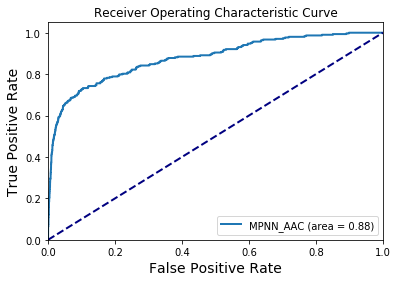

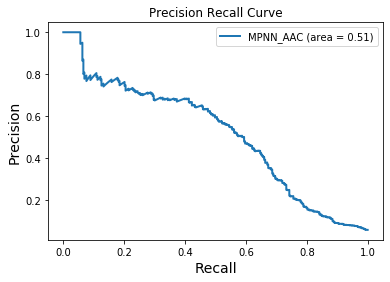

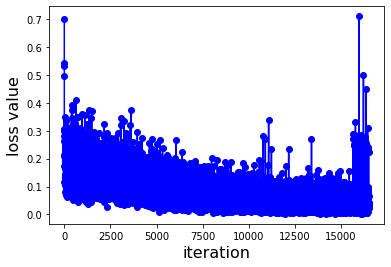

In [4]:
model = models.model_initialize(**config)
model.train(train, val, test)

In [9]:
train.to_csv('../data/MPNN_AAC/DeepPurpose_train_MPNN_AAC.csv')
val.to_csv('../data/MPNN_AAC/DeepPurpose_val_MPNN_AAC.csv')
test.to_csv('../data/MPNN_AAC/DeepPurpose_test_MPNN_AAC.csv')

In [11]:
ligands = list(set(train['SMILES'].tolist()))
targets = list(set(train['Target Sequence'].tolist()))

number_ligands = len(ligands)
number_targets = len(targets)
print('Ligands: ', number_ligands)
print('Targets: ',number_targets)

Ligands:  68
Targets:  379


(array([19996.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  1043.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

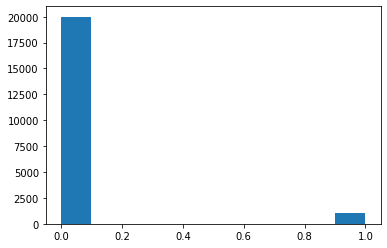

In [14]:
plt.hist(train['Label'])

In [12]:
ligands_degree_dict = dict()

for smile_chem in tqdm(ligands):
    sum_df = train[train['SMILES'] == smile_chem]
    ligands_degree_dict[smile_chem] = dict()
    ligands_degree_dict[smile_chem]['deg_0'] = len(sum_df[sum_df['Label'] == 0])
    ligands_degree_dict[smile_chem]['deg_1'] = len(sum_df[sum_df['Label'] == 1])
    
targets_degree_dict = dict()

for aa_target in tqdm(targets):
    sum_df = train[train['Target Sequence'] == aa_target]
    targets_degree_dict[aa_target] = dict()
    targets_degree_dict[aa_target]['deg_0'] = len(sum_df[sum_df['Label'] == 0])
    targets_degree_dict[aa_target]['deg_1'] = len(sum_df[sum_df['Label'] == 1])
    
degree_train_1_0_ligands = [ligands_degree_dict[key_val]['deg_1'] for key_val in tqdm(ligands_degree_dict.keys())]
degree_train_0_1_ligands = [ligands_degree_dict[key_val]['deg_0'] for key_val in tqdm(ligands_degree_dict.keys())]

degree_train_1_0_targets = [targets_degree_dict[key_val]['deg_1'] for key_val in tqdm(targets_degree_dict.keys())]
degree_train_0_1_targets = [targets_degree_dict[key_val]['deg_0'] for key_val in tqdm(targets_degree_dict.keys())]

100%|██████████| 379/379 [00:00<00:00, 399407.34it/s]


In [13]:
with open('../data/MPNN_AAC/degreetrain10ligands.txt', 'w') as file:
    for degree in degree_train_1_0_ligands:
        file.write("%i\n" % degree)
        
file.close()

with open('../data/MPNN_AAC/degreetrain01ligands.txt', 'w') as file:
    for degree in degree_train_0_1_ligands:
        file.write("%i\n" % degree)
        
file.close()

with open('../data/MPNN_AAC/degreetrain10targets.txt', 'w') as file:
    for degree in degree_train_1_0_targets:
        file.write("%i\n" % degree)
        
file.close()

with open('../data/MPNN_AAC/degreetrain01targets.txt', 'w') as file:
    for degree in degree_train_0_1_targets:
        file.write("%i\n" % degree)
        
file.close()

textfile = open("../data/MPNN_AAC/ligands.txt", "w")
for element in ligands:
    textfile.write(element + "\n")
textfile.close()

textfile = open("../data/MPNN_AAC/targets.txt", "w")
for element in targets:
    textfile.write(element + "\n")
textfile.close()

In [26]:
train_pos = train[train['Label'] == 1]
train_neg = train[train['Label'] == 0]

In [27]:
pos_deg_0_ligands = []
pos_deg_0_targets = []
neg_deg_0_ligands = []
neg_deg_0_targets = []

In [28]:
ligand_degree_ratio = dict()
ligand_all_average = []

for ligand in tqdm(ligands):
    pos_deg = len(train_pos[train_pos['SMILES'] == ligand])
    neg_deg = len(train_neg[train_neg['SMILES'] == ligand])
    ligand_degree_ratio[ligand] = dict()
    ligand_degree_ratio[ligand]['deg_ratio'] = pos_deg / (pos_deg + neg_deg)
    ligand_degree_ratio[ligand]['deg_avg'] = pos_deg / number_targets 
    ligand_all_average.append(pos_deg / number_targets)
    if pos_deg == 0:
        pos_deg_0_ligands.append(ligand)
    if neg_deg == 0:
        neg_deg_0_ligands.append(ligand)
    
ligands_all_avg = sum(ligand_all_average) / number_ligands

100%|██████████| 68/68 [00:00<00:00, 255.92it/s]


In [29]:
targets_degree_ratio = dict()
target_all_average = []

for target in tqdm(targets):
    pos_deg = len(train_pos[train_pos['Target Sequence'] == target])
    neg_deg = len(train_neg[train_neg['Target Sequence'] == target])
    targets_degree_ratio[target] = dict()
    targets_degree_ratio[target]['deg_ratio'] = pos_deg / (pos_deg + neg_deg)
    targets_degree_ratio[target]['deg_avg'] = pos_deg / number_ligands
    target_all_average.append(pos_deg / number_ligands)
    if pos_deg == 0:
        pos_deg_0_targets.append(target)
    if neg_deg == 0:
        neg_deg_0_targets.append(target)
    
targets_all_avg = sum(target_all_average) / number_targets

100%|██████████| 379/379 [00:01<00:00, 255.31it/s]


In [30]:
print('Ligands with positive degree 0: ',len(pos_deg_0_ligands))
print('Ligands with negative degree 0: ',len(neg_deg_0_ligands))
print('Targets with positive degree 0: ',len(pos_deg_0_targets))
print('Targets with negative degree 0: ',len(neg_deg_0_targets))

Ligands with positive degree 0:  7
Ligands with negative degree 0:  0
Targets with positive degree 0:  99
Targets with negative degree 0:  0


In [31]:
test_probabilty_predicted_naive = []

for index, row in tqdm(test.iterrows()):
    
    if row['SMILES'] in ligands and row['Target Sequence'] in targets:
        p_naive = ligand_degree_ratio[row['SMILES']]['deg_ratio'] * targets_degree_ratio[row['Target Sequence']]['deg_ratio']
        test_probabilty_predicted_naive.append(p_naive) 
    elif row['SMILES'] in ligands and row['Target Sequence'] not in targets:
        p_naive = ligand_degree_ratio[row['SMILES']]['deg_ratio']  
        test_probabilty_predicted_naive.append(p_naive) 
    elif row['SMILES'] not in ligands and row['Target Sequence'] in targets:
        p_naive = targets_degree_ratio[row['Target Sequence']]['deg_ratio'] 
        test_probabilty_predicted_naive.append(p_naive) 
    else:
        test_probabilty_predicted_naive.append(1)
        

6011it [00:00, 7607.99it/s]


In [32]:
## Performance on the test dataset

print('AUC: ', roc_auc_score(test['Label'].tolist(), test_probabilty_predicted_naive))
print('AUP: ', average_precision_score(test['Label'].tolist(), test_probabilty_predicted_naive))

AUC:  0.8251091051641956
AUP:  0.31416909222635664


In [19]:
test_preidcted = model.predict(test)
test['Y_predicted'] = test_preidcted

predicting...


In [16]:
train_ligands = list(set(train['SMILES'].tolist()))
train_targets = list(set(train['Target Sequence'].tolist()))

test_minus_train_ligands = list(set(test['SMILES'].tolist()).difference(train_ligands))
test_minus_train_targets = list(set(test['Target Sequence'].tolist()).difference(train_targets))

In [17]:
print('Seen ligands: ', len(train_ligands))
print('Seen targets: ', len(train_targets))
print('Unseen ligands: ', len(test_minus_train_ligands))
print('Unseen targets: ', len(test_minus_train_targets))

Seen ligands:  68
Seen targets:  379
Unseen ligands:  0
Unseen targets:  0


In [21]:
# Unseen Edges

test_unseen_edges = test[test['SMILES'].isin(train_ligands) & test['Target Sequence'].isin(train_targets)]
print('Unseen edges: ', len(test_unseen_edges))

print('AUC: ', roc_auc_score(test_unseen_edges['Label'].tolist(), test_unseen_edges['Y_predicted']))
print('AUP: ', average_precision_score(test_unseen_edges['Label'].tolist(), test_unseen_edges['Y_predicted']))

Unseen edges:  6011
AUC:  0.8783541020535132
AUP:  0.5103300172594729


In [22]:
# Unseen Targets

test_unseen_targets = test[test['Target Sequence'].isin(test_minus_train_targets)]
print('Unseen targets: ', len(test_unseen_targets))

print('AUC: ', roc_auc_score(test_unseen_targets['Label'].tolist(), test_unseen_targets['Y_predicted']))
print('AUP: ', average_precision_score(test_unseen_targets['Label'].tolist(), test_unseen_targets['Y_predicted']))

Unseen targets:  0


ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

In [25]:
# Unseen Nodes

test_unseen_nodes = test[test['SMILES'].isin(test_minus_train_ligands) & test['Target Sequence'].isin(test_minus_train_targets)]
print('Unseen nodes: ', len(test_unseen_nodes))

print('AUC: ', roc_auc_score(test_unseen_nodes['Label'].tolist(), test_unseen_nodes['Y_predicted']))
print('AUP: ', average_precision_score(test_unseen_nodes['Label'].tolist(), test_unseen_nodes['Y_predicted']))

Unseen nodes:  0


ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.